Import relevant packages

In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import s2wav.filters as filters
import matplotlib.pyplot as plt
%matplotlib inline 
import skyclean
from skyclean import CMB_data

Initialize a CMB_data object by provding the file path of the data

In [2]:
CMB_map_path = 'data/planck_simulation/ffp10_newdust_total_030_full_map.fits'
CMB_data_30 = skyclean.CMB_data.CMB_Data(CMB_map_path)

CMB_Data object created, (use show_attributes() to check the attributes)


Let's plot the CMB using the plot_mollview function inside the CMB_data object

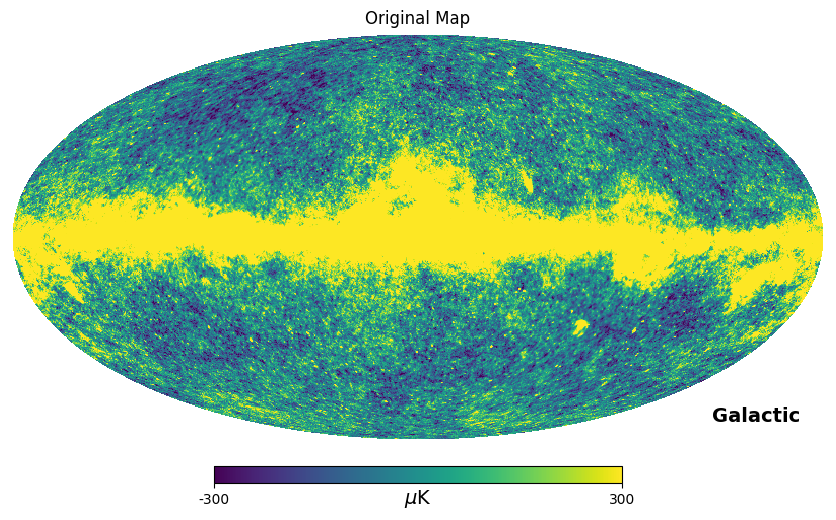

In [3]:
CMB_data_30.plot_mollview(CMB_data_30.original_hp_map, title='Original Map')

CMB_data_30.show_attributes

In [4]:
CMB_data_30.show_attributes()

Attributes:
 [['path', 'data/planck_simulation/ffp10_newdust_total_030_full_map.fits'], ['nside', 1024], ['lmax usually 2 * nisde', 2048]]
Maps:
 [['original_hp_map', 'Available'], ['original_mw_map', None], ['reconstructed_hp_map', None], ['reconstructed_mw_map', None]]
Alms:
 [['original_hp_alm', None], ['reconstructed_hp_alm', None]]
Wavelet_related:
 [['wavelet_coeff', None], ['Scaling_coeff', None]]


### Wavelet transform: s2wav.analysis

##### Step 1: Convert the map from HEALPix to MW

In [ ]:
# Step 1: Convert the map from HEALPix to MW

#Step 1.1:
# Using hp.map2alm to convert the original_hp_map to alm
CMB_data_30.original_hp_alm = hp.map2alm(CMB_data_30.original_hp_map, lmax=CMB_data_30.lmax-1)

# Step 1.2: Convert the hp_alm to mw_alm (From 1D to 2D)
CMB_data_30.original_mw_alm = CMB_data_30.hp_alm_to_mw_alm(CMB_data_30.original_hp_alm, lmax = CMB_data_30.lmax)

# Step 1.3: Convert the mw_alm to mw_map
CMB_data_30.original_mw_map = s2fft.inverse(CMB_data_30.original_mw_alm, L=CMB_data_30.lmax)



Step 2: Do the Wavelet Transform

In [ ]:
# Step 5: Apply s2wav to the MW map to get the wavelet and scaling coefficients
N_directions = 1  # Number of directional wavelets
filter = filters.filters_directional_vectorised(CMB_data_30.lmax, N_directions)

CMB_data_30.wavelet_coeff, CMB_data_30.Scaling_coeff = s2wav.analysis(CMB_data_30.original_mw_map, CMB_data_30.lmax, N_directions, filters=filter,reality = False)

# Convert each element in f_wav to a numpy array and save it
for i, wav in enumerate(CMB_data_30.wavelet_coeff):
    np_wav = np.array(wav)  # Convert JAX array to numpy array
    np.save(f"convolution/wavelet_coefficient/wav_30_{i}", np_wav)  

# Convert  f_scal to a numpy array and save it
np_scal = np.array(CMB_data_30.Scaling_coeff)  # Convert JAX array to numpy array
np.save(f"convolution/scaling_coefficient/scal_30", np_scal)  
stored_wavelet_coeffs = [np.load(f"convolution/wavelet_coefficient/wav_30_{i}.npy", allow_pickle=True) for i in range(12)]
stored_scaling_coeffs = np.load("convolution/scaling_coefficient/scal_30.npy")

In [ ]:
# Step 2: Wavelet Transform

In [ ]:
CMB_data_30.reconstructed_mw_map = s2wav.synthesis(stored_wavelet_coeffs, stored_scaling_coeffs, CMB_data_30.lmax, N_directions, filters=filter, reality = False)

reconstructed_MW_map = np.array(CMB_data_30.reconstructed_mw_map)
np.save(f"convolution/reconstructed_MW_map", CMB_data_30.reconstructed_mw_map)  # Save numpy array to a file
stored_reconstructed_MW_map = np.load("convolution/reconstructed_MW_map.npy")


In [ ]:
print(f"Mean absolute error = {np.nanmean(np.abs(CMB_data_30.reconstructed_mw_map - CMB_data_30.original_mw_map))}")

In [ ]:
CMB_data_30.reconstructed_mw_alm = s2fft.inverse(CMB_data_30.reconstructed_mw_map, L=CMB_data_30.lmax)

CMB_data_30.reconstructed_hp_alm = CMB_data_30.mw_alm_to_hp_alm(CMB_data_30.reconstructed_mw_alm, lmax = CMB_data_30.lmax)  

CMB_data_30.reconstructed_hp_map = hp.alm2map(CMB_data_30.reconstructed_hp_alm, nside=CMB_data_30.nside)
output_fits_path = 'reconstructed_healpix_map.fits'
hp.write_map(output_fits_path, CMB_data_30.reconstructed_hp_map, overwrite=True, dtype=np.float64)

CMB_data_30.plot_mollview(CMB_data_30.reconstructed_hp_map, title='Reconstructed Map')

In [ ]:
for i in range(12):
    # perform a forward transformation to convert 
    # the wavelet coefficients into the spherical harmonic alm space (2D).
    L_max = CMB_data_30.wavelet_coeff[i].shape[1]
    wavelet_in_alm = s2fft.forward(CMB_data_30.wavelet_coeff[i], L = L_max)
    alm_reconstructed_MW_map = wavelet_in_alm 
    
    np.save(f"convolution/alm_reconstructed_MW_map_{i}", alm_reconstructed_MW_map)  # Save numpy array to a file
    
    #Rearrange coefficients for healpy (1D).
    n_coeff = hp.Alm.getsize(L_max-1)
    reconstructed_healpix_alm_1 = np.zeros(n_coeff, dtype=np.complex128)
    
    for l in range(L_max):
        for m in range(-l, l + 1):
            alm_index = hp.Alm.getidx(L_max - 1, l, abs(m))
            if alm_index >= n_coeff:
                print(f"Index {alm_index} is out of bounds for alm with size {n_coeff}")
                continue
            if m < 0:
                reconstructed_healpix_alm_1[alm_index] = (-1) ** m * np.conj(alm_reconstructed_MW_map[l, L_max + m - 1])
            else:
                reconstructed_healpix_alm_1[alm_index] = alm_reconstructed_MW_map[l, L_max + m - 1]
 